In [52]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

%matplotlib inline


# create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()


In [58]:
query = \
"""
select * from all_data
"""
cur.execute('SET search_path to ' + schema_name)
data =  pd.read_sql_query(query, con)

In [59]:
data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,marital_status,...,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,MICU,MICU,76.526788,M,MARRIED,...,118.11,24.0,103.0,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0
1,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,SICU,SICU,65.940670,F,MARRIED,...,153.75,40.0,88.0,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,MICU,MICU,41.790226,M,None,...,149.72,47.0,194.0,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0
3,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,SICU,SICU,72.372364,M,MARRIED,...,152.03,45.0,111.0,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,CCU,CSRU,39.866116,F,None,...,132.27,39.0,90.0,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0


In [69]:
print ('Number of unique patient ids: {}'.format(len(data.subject_id.unique())))


Number of unique patient ids: 34005


Text(0,0.5,'')

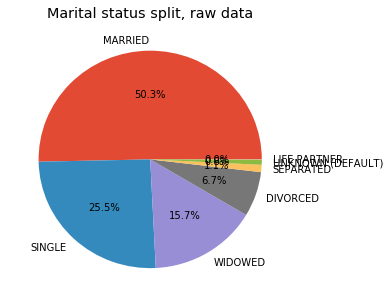

In [76]:
fig = plt.figure(figsize=(5,5))
data.marital_status.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Marital status split, raw data')
plt.ylabel('')

In [77]:
np.sum(data.isnull())

subject_id            0
hadm_id               0
admittime             0
dischtime             0
deathtime         37237
first_careunit        0
last_careunit         0
age                   0
gender                0
marital_status     2182
insurance             0
urea_n_min           33
urea_n_max           33
urea_n_mean          33
platelets_min        43
platelets_max        43
platelets_mean       43
magnesium_max       448
albumin_min       15204
calcium_min        1718
resprate_min         15
resprate_max         15
resprate_mean        15
glucose_min         358
glucose_max         358
glucose_mean        358
hr_min                2
hr_max                2
hr_mean               2
sysbp_min             8
sysbp_max             8
sysbp_mean            8
diasbp_min            8
diasbp_max            8
diasbp_mean           8
temp_min             89
temp_max             89
temp_mean            89
urine_min            11
urine_mean           11
urine_max            11
dtype: int64

In [78]:
# calculate time delta between subsequent readmissions of the same patient 
data['readmit_dt'] = np.zeros(data.shape[0])
data['next_readmit_dt'] = np.zeros(data.shape[0])
data['readmit_last_careunit'] = None

for idx in np.arange(1,data.shape[0]):
    if data.subject_id[idx] == data.subject_id[idx - 1]:     
        prev_disch = data.dischtime[idx-1]
        curr_adm = data.admittime[idx]
        dt = curr_adm - prev_disch
        dt_hrs_calc = np.round(dt.value/3600.0/1e9,2)

#         data.set_value(idx,'adm_num',data['adm_num'][idx-1] + 1) 
        data.set_value(idx,'readmit_dt',dt_hrs_calc)
        data.set_value(idx-1,'next_readmit_dt',dt_hrs_calc)
        data.set_value(idx,'readmit_last_careunit',data['last_careunit'][idx-1])

C:\Users\Haoyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\Haoyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
C:\Users\Haoyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


In [83]:
data.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,marital_status,...,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max,readmit_dt,next_readmit_dt,readmit_last_careunit
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,MICU,MICU,76.526788,M,MARRIED,...,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0,0.0,0.0,None
1,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,SICU,SICU,65.940670,F,MARRIED,...,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0,0.0,0.0,None
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,MICU,MICU,41.790226,M,None,...,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0,0.0,0.0,None
3,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,SICU,SICU,72.372364,M,MARRIED,...,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0,0.0,0.0,None
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,CCU,CSRU,39.866116,F,None,...,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0,0.0,0.0,None


In [84]:
data = data.drop(['urine_min','urine_mean','urine_max'], axis = 1) #Too noisy
data = data[data.readmit_dt >= 0] #Ignore cases where readmit_dt < 0, which result from duplicate records. 
data = data.ix[(data.deathtime.isnull())] #Remove cases where the patient died during stay
data = data.drop(['deathtime'], axis = 1) # Important to drop before dropna otherwise most of the data is lost
data = data.dropna(subset=data.keys()[:-1]).reset_index(drop = True) # Ignore NaN values in readmit_last_careunit

C:\Users\Haoyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
threshold = 30*24
data['future_readmit'] = None
data['future_readmit'] = ['No' if dt == 0.0 else 'Yes' if dt<=threshold else 'No' for dt in data.next_readmit_dt]

In [88]:
print ('Value counts:')
print (data.future_readmit.value_counts())
print ('\nValue proportions:')
print (data.future_readmit.value_counts()/data.shape[0])

Value counts:
No     18841
Yes     2081
Name: future_readmit, dtype: int64

Value proportions:
No     0.900535
Yes    0.099465
Name: future_readmit, dtype: float64


In [91]:
MICU_admits_clean = data.loc[data.first_careunit == 'MICU']
print ('Value counts:')
print (MICU_admits_clean.future_readmit.value_counts())
print ('\nValue proportions:')
print (MICU_admits_clean.future_readmit.value_counts()/MICU_admits_clean.shape[0])

Value counts:
No     7686
Yes     840
Name: future_readmit, dtype: int64

Value proportions:
No     0.901478
Yes    0.098522
Name: future_readmit, dtype: float64


In [92]:
MICU_admits_clean.to_csv('MICU_admits_clean.csv', index=False)
